In [115]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from IPython.display import display

import xgboost as xgb
from xgboost import plot_importance

import seaborn as sns
sns.set_style('darkgrid')

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif

In [116]:
# Load the dataset. If in kaggle, it will silently fall over and use the alternative path.
try:
    ds = pd.read_csv("nhis_00002.csv")
except FileNotFoundError:
    ds = pd.read_csv("/kaggle/input/nhis-00002/nhis_00002.csv")
type(ds)

pandas.core.frame.DataFrame

In [117]:
ds_len = len(ds)
print(ds_len)
ds.head()

75101


,YEAR,SERIAL,STRATA,PSU,NHISHID,PERNUM,NHISPID,HHX,SAMPWEIGHT,LONGWEIGHT,...,HEARTATTEV,LEARNDEV,RETEV,DIABETICAGE,SPEDEV,AEFFORT,ASAD,AWORTHLESS,SATISFIED,SATSCORE
0,2020,1,150,25,0002020H000002,1,0002020H00000210,H000002,5946.002,17605.50,...,1,0,0,96,0,NaN,NaN,NaN,NaN,NaN
1,2020,2,111,10,0002020H000003,1,0002020H00000310,H000003,6288.726,0.00,...,1,0,0,96,0,NaN,NaN,NaN,NaN,NaN
2,2020,3,133,3,0002020H000004,1,0002020H00000410,H000004,6083.271,0.00,...,1,0,0,96,0,NaN,NaN,NaN,NaN,NaN
3,2020,4,139,45,0002020H000007,1,0002020H00000710,H000007,11306.962,0.00,...,1,0,0,53,0,NaN,NaN,NaN,NaN,NaN
4,2020,5,130,21,0002020H000009,1,0002020H00000910,H000009,6471.818,19317.18,...,1,0,0,96,0,NaN,NaN,NaN,NaN,NaN


## Race Demographics

This dataset consists of 75,101 rows. The pie chart below displays the distribution of race demographics in the dataset.

For comparison, here are the Census Bureau estimates for the US population in 2020:

- White alone, not Hispanic or Latino: 60.1%
- Black or African American alone: 13.4%
- American Indian and Alaska Native alone: 1.0%
- Asian alone: 6.0%
- Native Hawaiian and Other Pacific Islander alone: 0.2%
- Some other race alone: 2.7%
- Two or more races: 7.8%
- Hispanic or Latino (of any race): 18.7%

Source: https://www.census.gov/quickfacts/fact/table/US/PST045222

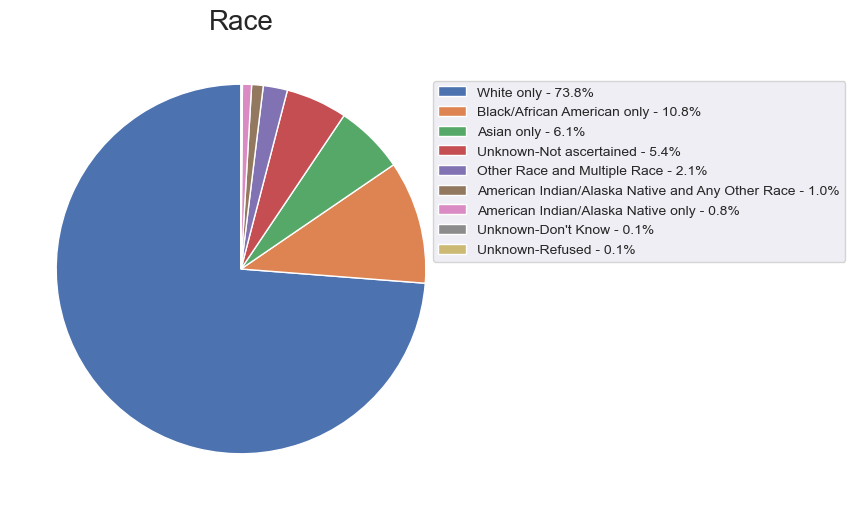

In [118]:
# Create a dictionary to map the race code to the actual race label
code_to_race = {
    100: 'White only',
    200: 'Black/African American only',
    300: 'American Indian/Alaska Native only',
    400: 'Asian only',
    510: 'Other Race and Multiple Race',
    542: 'American Indian/Alaska Native and Any Other Race',
    997: 'Unknown-Refused',
    998: 'Unknown-Not ascertained',
    999: "Unknown-Don't Know"
}

# Count the number of responses for each race code in the dataset
counts = ds['RACENEW'].value_counts()

# Create a list of the actual race labels using the dictionary
labels = [code_to_race[code] for code in counts.index]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the pie chart
ax.pie(counts, startangle=90)
ax.legend(loc="lower left", bbox_to_anchor=(0.9, 0.5), ncol=1, fontsize=10,
          labels=['{} - {:.1f}%'.format(l, c/sum(counts)*100) for l, c in zip(labels, counts)])
ax.set_title("Race", size=20)
plt.show()

## Gender Demographics

The chart below shows the gender distribution in the sample compared to the US population based on US census data.

As of 2020, the US population is estimated to be 50.8% female and 49.2% male

Total excluded rows: 10


Text(0.5, 1.0, 'Gender')

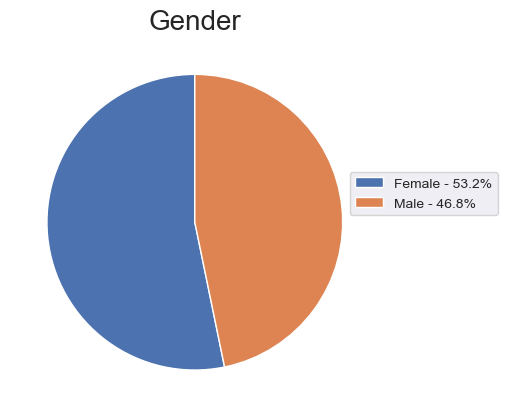

In [119]:
code_to_gender = {
    1: 'Male',
    2: 'Female',
    7: 'Unknown-refused',
    8: 'Unknown-not ascertained',
    9: "Unknown-don't know"
}

# Codes 7, 8 and 9 represents a total of 10 values, and is too miniscule to carry a percentage.
filtered_ds = ds.loc[ds['SEX'].isin([1, 2])]
counts = filtered_ds['SEX'].value_counts()
total_counts = counts.sum()
print (f"Total excluded rows: {ds_len - total_counts}")
labels = [code_to_gender[code] for code in counts.index]
plt.pie(counts, startangle=90, autopct='')
plt.legend(loc="lower left", bbox_to_anchor=(0.9, 0.5), ncol=1, fontsize=10, 
           labels=['{} - {:.1f}%'.format(l, c/sum(counts)*100) for l, c in zip(labels, counts)])
plt.title("Gender", size=20)


### Family Income

24.0    12027
11.0     9136
22.0     6699
23.0     4855
12.0     4641
Name: INCFAM07ON, dtype: int64


Text(0.5, 1.0, 'Family Income')

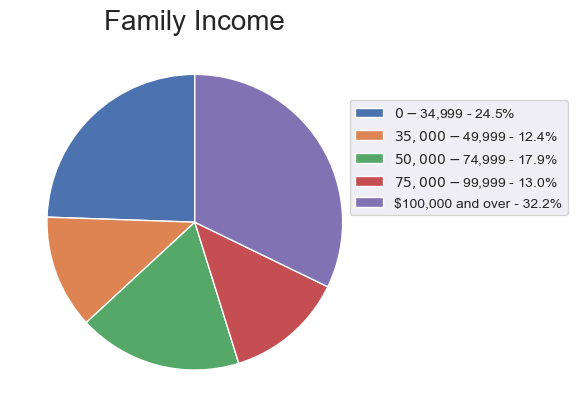

In [120]:
# Define a dictionary that maps income codes to income ranges
code_to_income = {
    11: '$0 - $34,999',
    12: '$35,000 - $49,999',
    22: '$50,000 - $74,999',
    23: '$75,000 - $99,999',
    24: '$100,000 and over'
}

# Get the counts for each income code in the dataset
counts = ds['INCFAM07ON'].value_counts()
print(counts)

# Get the labels for each income code
labels = [code_to_income[code] for code in counts.index]

# Sort the counts and labels in order of the income ranges
counts, labels = zip(*sorted(zip(counts, labels), key=lambda x: list(code_to_income.values()).index(x[1])))

# Create the pie chart
plt.pie(counts, startangle=90, autopct='')
plt.legend(loc="lower left", bbox_to_anchor=(0.9, 0.5), ncol=1, fontsize=10,
           labels=['{} - {:.1f}%'.format(l, c/sum(counts)*100) for l, c in zip(labels, counts) if c != 0])
plt.title("Family Income", size=20)


## Defining protected features
HEALTH
1                   Excellent
2                   Very Good
3                   Good
4                   Fair
5                   Poor
7                   Unknown-refused
8                   Unknown-not ascertained
9                   Unknown-don't know

2    24149
1    23239
3    18497
4     7074
5     2105
7       21
9       16
Name: HEALTH, dtype: int64


Text(0.5, 1.0, 'Health')

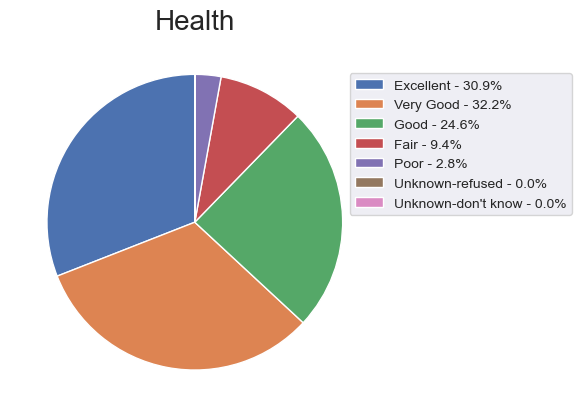

In [121]:
# Define a dictionary that maps income codes to income ranges
code_to_health = {
    1: 'Excellent',
    2: 'Very Good',
    3: 'Good',
    4: 'Fair',
    5: 'Poor',
    7: 'Unknown-refused',
    8: 'Unknown-not ascertained',
    9: "Unknown-don't know"
}

# Get the counts for each income code in the dataset
counts = ds['HEALTH'].value_counts()
print(counts)

# Get the labels for each income code
labels = [code_to_health[code] for code in counts.index]

# Sort the counts and labels in order of the income ranges
counts, labels = zip(*sorted(zip(counts, labels), key=lambda x: list(code_to_health.values()).index(x[1])))

# Create the pie chart
plt.pie(counts, startangle=90, autopct='')
plt.legend(loc="lower left", bbox_to_anchor=(0.9, 0.5), ncol=1, fontsize=10,
           labels=['{} - {:.1f}%'.format(l, c/sum(counts)*100) for l, c in zip(labels, counts) if c != 0])
plt.title("Health", size=20)

In [122]:
# Create a new dataframe with only the necessary columns
ds_fair = ds[['RACENEW', 'INCFAM07ON', 'SEX']]

# Rename the columns for clarity
ds_fair = ds_fair.rename(columns={'RACENEW': 'race', 'INCFAM07ON': 'income', 'SEX': 'sex'})

# Define privileged race and income. 100 is white, 24 is 100k+
privileged_race = 100
privileged_income = [24]
privileged_sex = [1]

# Create the privileged variables
ds_fair['priv_race'] = ds_fair['race'].apply(lambda x: 1 if x == privileged_race else 0)
ds_fair['priv_income'] = ds_fair['income'].apply(lambda x: 1 if x in privileged_income else 0)
ds_fair['priv_sex'] = ds_fair['sex'].apply(lambda x: 1 if x in privileged_sex else 0)

ds_fair['y'] = [1 if y == 1 else 0 for y in ds['HEALTH']]
display(ds_fair[:15])

,race,income,sex,priv_race,priv_income,priv_sex,y
0,100,11.0,2,1,0,0,1
1,100,24.0,1,1,1,1,0
2,100,24.0,2,1,1,0,0
3,100,22.0,1,1,0,1,0
4,100,23.0,2,1,0,0,0
5,100,24.0,1,1,1,1,0
6,100,23.0,1,1,0,1,1
7,542,24.0,2,0,1,0,0
8,100,12.0,2,1,0,0,1
9,200,11.0,2,0,0,0,0


## Prevalence of protected features

In [123]:
# Calculate prevalence
prev = ds_fair['y'].mean()
prev_race = ds_fair.groupby('priv_race')['y'].mean()
prev_income = ds_fair.groupby('priv_income')['y'].mean()
#prev_sex = ds_fair.groupby('priv_sex')['y'].mean()
prev_comb = ds_fair.groupby(['priv_income','priv_race'])['y'].mean()

print(prev)
print(prev_race)
print(prev_income)
#print(prev_sex)
print(prev_comb)

0.30943662534453603
priv_race
0    0.325583
1    0.303696
Name: y, dtype: float64
priv_income
0    0.290579
1    0.408331
Name: y, dtype: float64
priv_income  priv_race
0            0            0.314076
             1            0.281619
1            0            0.413310
             1            0.407164
Name: y, dtype: float64


### Proxy Variable

In [124]:
y = [1 if y == 1 else 0 for y in ds['HEALTH']]

#Model features
X = ds[['SEXORIEN','EDUC', 'CITIZEN', 'OWNERSHIP', 'HINOTCOVE']]
#X['marital-status'] = [1 if x=='Married-civ-spouse' else 0 for x in df['marital-status']]
#X['native-country'] = [1 if x=='United-States' else 0 for x in df['native-country']]

edu_groups = {
    000: -1,  # Unknown/NIU
    100: 0,   # Grade 12 or less, no high school diploma or equivalent
    102: 0,   # Never attended/kindergarten only
    103: 0,   # Grade 1-11
    113: 0,   # Grade 9
    114: 0,   # Grade 10
    115: 0,   # Grade 11
    116: 0,   # 12th grade, no diploma
    200: 1,   # High school diploma or GED
    201: 1,   # High school graduate
    202: 1,   # GED or equivalent
    300: 2,   # Some college, no 4yr degree
    301: 2,   # Some college, no degree
    302: 2,   # AA degree: technical/vocational/occupational
    303: 2,   # AA degree: academic program
    400: 3,   # Bachelor's degree (BA,AB,BS,BBA)
    500: 4,   # Master's, Professional, or Doctoral Degree
    501: 4,   # Master's degree (MA,MS,Med,MBA)
    502: 4,   # Professional (MD,DDS,DVM,JD)
    503: 4,   # Doctoral degree (PhD, EdD)
    504: 4,   # Other degree
    505: 4,   # Professional School or Doctoral degree, topcoded (MD, DDS, DVM, JD, PhD, EdD)
    996: -1,  # No degree, years of education unknown
    997: -1,  # Unknown--refused
    998: -1,  # Unknown--not ascertained
    999: -1   # Unknown--don't know
}

orien_groups = {
    0: -1,    # NIU
    1: 0,     # Lesbian or gay
    2: 1,     # Straight
    3: 0,     # Bisexual
    4: 0,     # Something else
    5: 0,     # Don't know
    7: -1,    # Refused
    8: -1,    # Not ascertained
}

citizen_groups = {
    1: 0,  # No, not U.S. citizen
    2: 1,  # Yes, U.S. citizen
    7: -1,  # Unknown--refused
    8: -1,  # Unknown--not ascertained
    9: -1,  # Unknown--don't know
}

ownership_group = {00: -1,
                  10: 1,
                  11: 1,
                  12: 1,
                  20: 0,
                  30: 0,
                  40: 0,
                  97: -1,
                  98: -1,
                  99: -1}

insurance_group = {
    0: -1,  # NIU
    1: 1,   # Has coverage
    2: 0,   # Has no coverage
    7: -1,  # Unknown-refused
    8: -1,  # Unknown-not ascertained
    9: -1,  # Unknown-don't know
}


X['EDUC'] = [edu_groups[x] for x in ds['EDUC']]
X['SEXORIEN'] = [orien_groups[x] for x in ds['SEXORIEN']]
X['CITIZEN'] = [citizen_groups[x] for x in ds['CITIZEN']]
X['OWNERSHIP'] = [ownership_group[x] for x in ds['OWNERSHIP']]
X['HINOTCOVE'] = [insurance_group[x] for x in ds['HINOTCOVE']]

X.head()

,SEXORIEN,EDUC,CITIZEN,OWNERSHIP,HINOTCOVE
0,1,4,1,1,1
1,1,4,1,1,1
2,1,4,1,1,1
3,1,0,-1,-1,1
4,1,3,1,-1,0


<Figure size 1000x500 with 0 Axes>

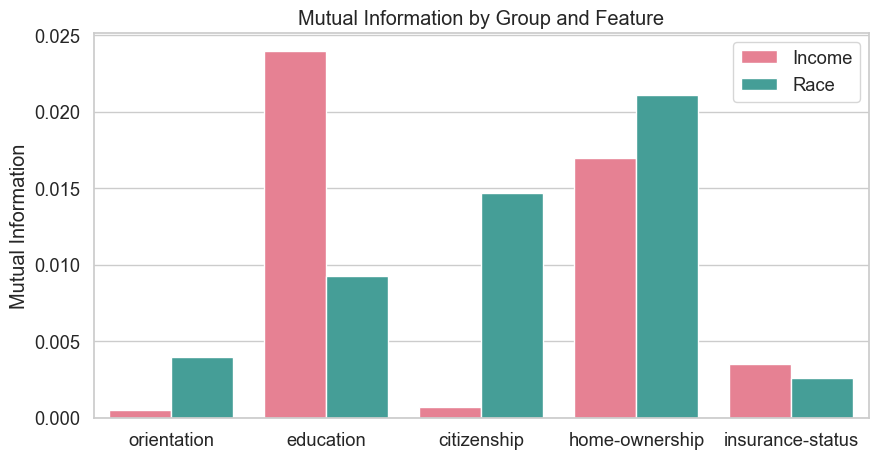

In [125]:
mut_income = mutual_info_classif(X,ds_fair['priv_income'],discrete_features=[0,1,2,3,4])
#mut_sex = mutual_info_classif(X,ds_fair['priv_sex'],discrete_features=[0,1,2,3,4])
mut_race = mutual_info_classif(X,ds_fair['priv_race'],discrete_features=[0,1,2,3,4])

plt.figure(figsize=(10, 5))

labels = ['orientation', 'education', 'citizenship', 'home-ownership',
          'insurance-status']
data = {'Mutual Information': np.concatenate((mut_income, mut_race)),
        'Feature': np.concatenate((labels, labels)),
        'Group': ['Income'] * len(mut_income) + ['Race'] * len(mut_race)}

sns.set(style='whitegrid', font_scale=1.2)
plt.figure(figsize=(10, 5))
sns.barplot(x='Feature', y='Mutual Information', hue='Group', data=data, palette='husl')
plt.xlabel('')
plt.ylabel('Mutual Information')
plt.title('Mutual Information by Group and Feature')
plt.show()

In [126]:
#Feature importance race

# Get balanced sample
y_race_0 = ds_fair[ds_fair['priv_race'] == 0]['priv_race']
y_race_1 = ds_fair[ds_fair['priv_race'] == 1]['priv_race']
y_race_1 = y_race_1.sample(len(y_race_0))
y_race = pd.concat([y_race_0, y_race_1])

X_race = X.loc[y_race.index]

#Train model and get predictions
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_race, y_race)
y_pred = model.predict(X_race)

#Calculate accuracy
acc_race = accuracy_score(y_race, y_pred)

#Get feature importance
fi_race = model.get_booster().get_score(importance_type='weight')


#Output results
print(acc_race)
print(confusion_matrix(y_race, y_pred))
print(classification_report(y_race, y_pred))

0.6329897954003147
[[13376  6321]
 [ 8137 11560]]
              precision    recall  f1-score   support

           0       0.62      0.68      0.65     19697
           1       0.65      0.59      0.62     19697

    accuracy                           0.63     39394
   macro avg       0.63      0.63      0.63     39394
weighted avg       0.63      0.63      0.63     39394



In [127]:
# Get balanced sample
y_income_0 = ds_fair[ds_fair['priv_income'] == 0]['priv_income']
y_income_1 = ds_fair[ds_fair['priv_income'] == 1]['priv_income']
y_income_1 = y_income_1.sample(len(y_income_0), replace=True)
y_income = pd.concat([y_income_0, y_income_1])

X_income = X.loc[y_income.index]

#Train model and get predictions
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_income, y_income)

y_pred = model.predict(X_income)

#Calculate accuracy
acc_income = accuracy_score(y_income, y_pred)

#Get feature importance
fi_income = model.get_booster().get_score(importance_type='weight')

#Output results
print(acc_income)
print(confusion_matrix(y_income, y_pred))
print(classification_report(y_income, y_pred))

0.6589878555347687
[[33279 29795]
 [13223 49851]]
              precision    recall  f1-score   support

           0       0.72      0.53      0.61     63074
           1       0.63      0.79      0.70     63074

    accuracy                           0.66    126148
   macro avg       0.67      0.66      0.65    126148
weighted avg       0.67      0.66      0.65    126148



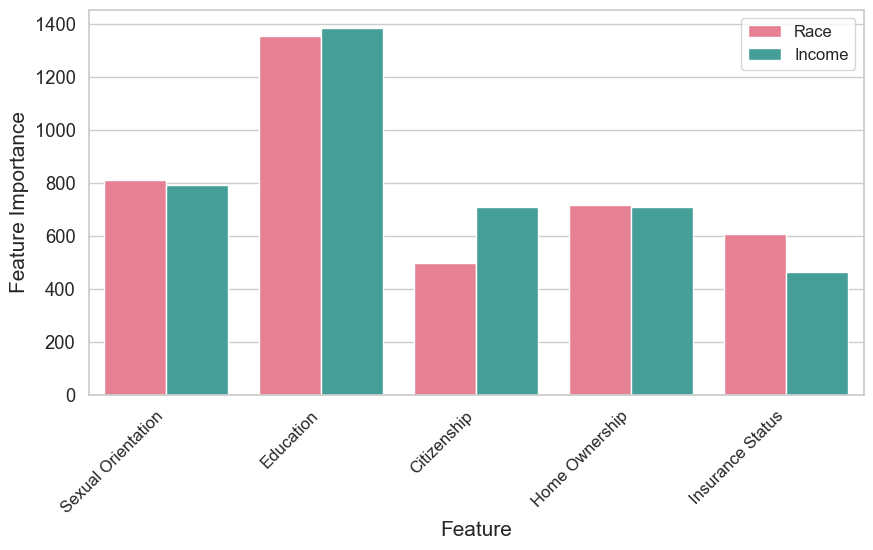

In [128]:
# Rename the columns
friendly_labels = {'SEXORIEN': 'Sexual Orientation', 'EDUC': 'Education',
                   'CITIZEN': 'Citizenship', 'OWNERSHIP': 'Home Ownership',
                   'HINOTCOVE': 'Insurance Status'}
labels = ['SEXORIEN','EDUC', 'CITIZEN', 'OWNERSHIP', 'HINOTCOVE']

# Create separate lists for feature importances
fi_race = [fi_race[l] for l in labels]
fi_income = [fi_income[l] for l in labels]
labels = [friendly_labels[l] for l in labels]
# Combine the data into a single DataFrame
data = pd.DataFrame({'Feature': labels, 'Race': pd.Series(fi_race), 'Income': pd.Series(fi_income)})

# Melt the DataFrame into long format
data_melted = data.melt(id_vars='Feature', var_name='Group', value_name='Feature Importance')

# Create the barplot using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x='Feature', y='Feature Importance', hue='Group', data=data_melted, palette='husl')
plt.ylabel('Feature Importance',size=15)
plt.xticks(rotation=45, ha='right', size=12)
plt.xlabel('Feature',size=15)
plt.legend(fontsize=12)

In [129]:
#Train model
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X, y)

#Get predictions
y_pred = model.predict(X)
ds_fair['y_pred'] = y_pred

print(confusion_matrix(y, y_pred))
print(accuracy_score(y, y_pred))
print(classification_report(y, y_pred))

[[47151  4711]
 [13859  9380]]
0.7527329862451898
              precision    recall  f1-score   support

           0       0.77      0.91      0.84     51862
           1       0.67      0.40      0.50     23239

    accuracy                           0.75     75101
   macro avg       0.72      0.66      0.67     75101
weighted avg       0.74      0.75      0.73     75101



In [130]:
def fairness_metrics(df):

    #Confusion Matrix
    cm=confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()

    N = TP+FP+FN+TN

    # Overall accuracy
    ACC = (TP+TN)/N

    # True positive rate
    TPR = TP/(TP+FN)

    # False positive rate
    FPR = FP/(FP+TN)

    # False negative rate
    FNR = FN/(TP+FN)

    # Percentage predicted as positive
    PPP = (TP + FP)/N

    return np.array([ACC, TPR, FPR, FNR, PPP])

In [131]:
#Calculate fairness metrics for race
fm_race_1 = fairness_metrics(ds_fair[ds_fair.priv_race==1])
fm_race_0 = fairness_metrics(ds_fair[ds_fair.priv_race==0])

#Get ratio of fairness metrics
fm_race = fm_race_0/fm_race_1

print(fm_race_1)
print(fm_race_0)
print(fm_race)

[0.75851924 0.37911565 0.07600187 0.62088435 0.16805646]
[0.73645733 0.46795571 0.13392051 0.53204429 0.24267655]
[0.9709145  1.23433498 1.76206865 0.85691367 1.444018  ]


In [132]:
#Calculate fairness metrics for income
fm_income_1 = fairness_metrics(ds_fair[ds_fair.priv_income==1])
fm_income_0 = fairness_metrics(ds_fair[ds_fair.priv_income==0])


#Get ratio of fairness metrics
fm_income = fm_income_0/fm_income_1

print(fm_income_1)
print(fm_income_0)
print(fm_income)

[0.68786896 0.368764   0.09190556 0.631236   0.20495552]
[0.76510131 0.41297468 0.09066732 0.58702532 0.18432318]
[1.1122777  1.11988883 0.98652701 0.92996172 0.89933259]
